<a href="https://colab.research.google.com/github/shawnpadda/-Application-and-Analysis-of-Bootstrapping-Methods-on-a-Walmart-Dataset/blob/main/FIFA2021_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Application of ETL Pipeline, Descriptive Statistics, Inferential Statistics, and Machine learning on FIFA 2021 Data Set***

* **Data Cleaning using an ETL Pipeline**

In [ ]:
!pip install bioinfokit
import pandas as pd
import numpy as np
import sqlite3
import warnings
import seaborn as sns
from sqlalchemy import create_engine
import sqlite3 as sql
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import ranksums
from bioinfokit.analys import stat
from scipy.stats import chi2_contingency
from scipy.stats.stats import pearsonr
from scipy.stats import spearmanr
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn import tree
import pydotplus
from IPython.display import Image
import graphviz
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Extracting Data from SQLite Database**

In [ ]:
# Connect to SQLite database.
engine = create_engine('sqlite:////content/sample_data/FIFA2021.db', echo=True)
sqlite_connection = engine.connect()

In [ ]:
query = 'select * from fifa2021'

In [ ]:
newdf = pd.read_sql(query, engine)

2022-08-01 18:39:33,197 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("select * from fifa2021")
2022-08-01 18:39:33,205 INFO sqlalchemy.engine.Engine [raw sql] ()
2022-08-01 18:39:33,210 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("select * from fifa2021")
2022-08-01 18:39:33,213 INFO sqlalchemy.engine.Engine [raw sql] ()
2022-08-01 18:39:33,216 INFO sqlalchemy.engine.Engine select * from fifa2021
2022-08-01 18:39:33,219 INFO sqlalchemy.engine.Engine [raw sql] ()


In [ ]:
newdf.drop(["Column1","field1","LongName"], axis = 1, inplace = True)

In [ ]:
# Identify all duplicated data
duplicate_newdf = newdf[newdf.duplicated(keep = False)]
print(f'No. of duplicate rows:{duplicate_newdf.shape[0]}')

No. of duplicate rows:0


In [ ]:
newdf.head()

,Name,Nationality,Age,↓OVA,POT,Club,Contract,Positions,Height,Weight,...,A/W,D/W,IR,PAC,SHO,PAS,DRI,DEF,PHY,Hits
0,L. Messi,Argentina,33,93,93,FC Barcelona,2004 ~ 2021,"RW, ST, CF",170cm,72kg,...,Medium,Low,5 ★,85,92,91,95,38,65,771
1,Cristiano Ronaldo,Portugal,35,92,92,Juventus,2018 ~ 2022,"ST, LW",187cm,83kg,...,High,Low,5 ★,89,93,81,89,35,77,562
2,J. Oblak,Slovenia,27,91,93,Atlético Madrid,2014 ~ 2023,GK,188cm,87kg,...,Medium,Medium,3 ★,87,92,78,90,52,90,150
3,K. De Bruyne,Belgium,29,91,91,Manchester City,2015 ~ 2023,"CAM, CM",181cm,70kg,...,High,High,4 ★,76,86,93,88,64,78,207
4,Neymar Jr,Brazil,28,91,91,Paris Saint-Germain,2017 ~ 2022,"LW, CAM",175cm,68kg,...,High,Medium,5 ★,91,85,86,94,36,59,595


In [ ]:
def calc_percent_NAs(df): #create the NA report file
    nans = pd.DataFrame(df.isnull().sum().sort_values(ascending=False)/len(df), columns=['Percent'])
    idx = nans['Percent'] > 0
    return nans[idx]
report1 = newdf.isna().sum()
report2 = calc_percent_NAs(newdf).head(100)
pd.concat([report1.rename("Total_NA"),
          (report2*100).round(2)], axis=1).to_pickle("r2.pickle")

# Call calc_percent_NAs
calc_percent_NAs(newdf)

,Percent
Hits,0.13673


In [ ]:
# Count missing values in each column in the data frame
missing_data = newdf.isnull()
# Run a for loop
for i in missing_data.columns.values.view():
      if missing_data[i].any() == True:
           print(i)
           print(missing_data[i].value_counts())
           total = len(newdf)
           print("")
           print('In Percentage(%):\n{}'.format(round(missing_data[i].value_counts()/total*100),2))
      elif missing_data.columns.any() == False:
           print(i)
           print(missing_data[i].value_counts())
           print("")

Hits
False    16384
True      2595
Name: Hits, dtype: int64

In Percentage(%):
False    86.0
True     14.0
Name: Hits, dtype: float64


**Data Transformation - I**

In [ ]:
# Data cleaning 1- Trim whitespaces, remove question marks,symbols
newdf["Name"] = newdf["Name"].str.replace("�.","",regex = True)
newdf['Club'] = newdf['Club'].replace({'\n\n\n\n':'',"1.":""},regex = True)

# Transform Contract variable
newdf["Contract"] = newdf["Contract"].replace({"~":"-","On Loan":"_OnLoan","Free":"_Free"},regex = True)
newdf["Contract_Loan"] = newdf.Contract.str.split("_").str[1]
newdf['Contract_Status'] = newdf['Contract_Loan'].map(lambda x: 'Free' if x == "Free" else ('OnLoan' if x == "OnLoan" else 'Not OnLoan'))

# Transforming Weight variable
newdf["Weight"] = newdf["Weight"].replace({"lbs":"_lbs","kg":"_kg"},regex = True)

# Transforming Height variable
newdf["Height"] = newdf["Height"].replace({"cm":"_cm","\"":"","'": "_"}, regex = True).astype(str)

newdf['IR'] = newdf['IR'].str.replace('★', '')
newdf['W/F'] = newdf['W/F'].str.replace('★', '')
newdf['SM'] = newdf['SM'].str.replace('★', '')

# Transforming Value and WAGE VARIABLES
newdf['Value'] = newdf['Value'].replace({'€': '', ' ': '', 'M': 'e+06', 'K': 'e+03'}, regex=True).astype(float).astype(int)
newdf['Wage'] = newdf['Wage'].replace({'€': '', ' ': '', 'K': 'e+03'}, regex=True).astype(float).astype(int)

# Transforming Hits variable
newdf["Hits"] = newdf["Hits"].replace({'K': '*1e3',np.nan:0}, regex=True).map(pd.eval)


newdf["ReleaseClause"] = newdf["ReleaseClause"].replace({'€': '', ' ': '', 'M': 'e+06', 'K': 'e+03'}, regex=True).astype(float).astype(int)
newdf['Joined']= pd.to_datetime(newdf['Joined'])
newdf

,Name,Nationality,Age,↓OVA,POT,Club,Contract,Positions,Height,Weight,...,IR,PAC,SHO,PAS,DRI,DEF,PHY,Hits,Contract_Loan,Contract_Status
0,L. Messi,Argentina,33,93,93,FC Barcelona,2004 - 2021,"RW, ST, CF",170_cm,72_kg,...,5,85,92,91,95,38,65,771.0,NaN,Not OnLoan
1,Cristiano Ronaldo,Portugal,35,92,92,Juventus,2018 - 2022,"ST, LW",187_cm,83_kg,...,5,89,93,81,89,35,77,562.0,NaN,Not OnLoan
2,J. Oblak,Slovenia,27,91,93,Atlético Madrid,2014 - 2023,GK,188_cm,87_kg,...,3,87,92,78,90,52,90,150.0,NaN,Not OnLoan
3,K. De Bruyne,Belgium,29,91,91,Manchester City,2015 - 2023,"CAM, CM",181_cm,70_kg,...,4,76,86,93,88,64,78,207.0,NaN,Not OnLoan
4,Neymar Jr,Brazil,28,91,91,Paris Saint-Germain,2017 - 2022,"LW, CAM",175_cm,68_kg,...,5,91,85,86,94,36,59,595.0,NaN,Not OnLoan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18974,Xia Ao,China PR,21,47,55,Wuhan Zall,2018 - 2022,CB,178_cm,66_kg,...,1,64,28,26,38,48,51,0.0,NaN,Not OnLoan
18975,B. Hough,England,17,47,67,Oldham Athletic,2020 - 2021,CM,175_cm,65_kg,...,1,64,40,48,49,35,45,0.0,NaN,Not OnLoan
18976,R. McKinley,England,18,47,65,Derry City,2019 - 2020,CM,179_cm,74_kg,...,1,63,39,44,46,40,53,0.0,NaN,Not OnLoan
18977,Wang Zhen'ao,China PR,20,47,57,Dalian YiFang FC,2020 - 2022,RW,175_cm,69_kg,...,1,58,49,41,49,30,44,0.0,NaN,Not OnLoan


In [ ]:
# Transforming the weight Variable
newdf["Weight_unit"] = newdf.Weight.str.split("_").str[1]
newdf["wgt"] = newdf.Weight.str.split("_").str[0].astype(int)

# Convert weight into lbs unit
vals = {'kg':2.205,'lbs':1}

newdf['new_wgt'] = newdf['wgt']*newdf['Weight_unit'].map(vals)

In [ ]:
# Transforming the height Variable
warnings.filterwarnings("ignore")

# Split the height unit
newdf["Height_unit"] = newdf.Height.str.split("_").str[1]
newdf["Hgt"] = newdf.Height.str.split("_").str[0]


# Subset the data frame into newdf1 and newdf2.
newdf1 = newdf[newdf["Height_unit"]!= "cm"]
newdf2 = newdf[newdf["Height_unit"]== "cm"]

# Standardize the height in cm
newdf1['feet'] = newdf1['Height'].apply(lambda x: int(x.split('_')[0]))
newdf1['inches'] = newdf1['Height'].apply(lambda x: int(x.split('_')[1]))
newdf1['feet_in_cm'] = newdf1['feet'] * 30.48
newdf1['inches_in_cm'] = newdf1['inches'] * 2.54
newdf1['Hgt'] = newdf1['feet_in_cm'] + newdf1['inches_in_cm']
newdf2["Hgt"] = newdf2["Hgt"].astype(int)
new_df = newdf2.append(newdf1, sort = True)

**Data Transformation - II**

In [ ]:
# Drop an unnecessary variables
new_df = new_df.drop(['Contract',"Contract_Loan","Weight_unit","wgt","Height_unit","Height",
                      "Weight","feet","feet_in_cm","inches_in_cm","inches"],axis = 1)

# Rename the variables: Weight and height
new_df.rename(columns = {"Hgt":"Height","new_wgt":"Weight"}, inplace = True)

In [ ]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18979 entries, 0 to 898
Data columns (total 72 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   A/W              18979 non-null  object        
 1   Acceleration     18979 non-null  int64         
 2   Age              18979 non-null  int64         
 3   Aggression       18979 non-null  int64         
 4   Agility          18979 non-null  int64         
 5   Attacking        18979 non-null  int64         
 6   BOV              18979 non-null  int64         
 7   Balance          18979 non-null  int64         
 8   BallControl      18979 non-null  int64         
 9   BaseStats        18979 non-null  int64         
 10  BestPosition     18979 non-null  object        
 11  Club             18979 non-null  object        
 12  Composure        18979 non-null  int64         
 13  Contract_Status  18979 non-null  object        
 14  Crossing         18979 non-null  int64  

**Loading Pandas Data freme to SQLite Database**

In [ ]:
sqlite_table = "FIFA2021WorldCup"
new_df.to_sql(sqlite_table, sqlite_connection, if_exists='replace')

2022-08-01 18:39:45,001 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("FIFA2021WorldCup")
2022-08-01 18:39:45,008 INFO sqlalchemy.engine.Engine [raw sql] ()
2022-08-01 18:39:45,016 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("FIFA2021WorldCup")
2022-08-01 18:39:45,036 INFO sqlalchemy.engine.Engine [raw sql] ()
2022-08-01 18:39:45,075 INFO sqlalchemy.engine.Engine 
CREATE TABLE "FIFA2021WorldCup" (
	"index" BIGINT, 
	"A/W" TEXT, 
	"Acceleration" BIGINT, 
	"Age" BIGINT, 
	"Aggression" BIGINT, 
	"Agility" BIGINT, 
	"Attacking" BIGINT, 
	"BOV" BIGINT, 
	"Balance" BIGINT, 
	"BallControl" BIGINT, 
	"BaseStats" BIGINT, 
	"BestPosition" TEXT, 
	"Club" TEXT, 
	"Composure" BIGINT, 
	"Contract_Status" TEXT, 
	"Crossing" BIGINT, 
	"Curve" BIGINT, 
	"D/W" TEXT, 
	"DEF" BIGINT, 
	"DRI" BIGINT, 
	"Defending" BIGINT, 
	"Dribbling" BIGINT, 
	"FKAccuracy" BIGINT, 
	"Finishing" BIGINT, 
	"GKDiving" BIGINT, 
	"GKHandling" BIGINT, 
	"GKKicking" BIGINT, 
	"GKPositioning" BIGINT, 
	"GKReflexe

In [ ]:
sqlite_connection.close()

**Descriptive Summary Statistics**

In [ ]:
# Produce Contingency tables
n1 = new_df.select_dtypes(include = 'object').columns # Object data type variables
n2 = new_df.select_dtypes(include = 'int').columns # int data type variables


# Get count for each variable by targeting both groups
def count(df,tab):
   out = []
   for i in df.loc[:,tab]:
     a = pd.crosstab(df[i] ,df['PreferredFoot'] , margins = True,
                     margins_name = "Total").astype(str).apply(lambda x:x + '  ')
     out.append(a)
   return(out)

count(new_df,n1)

[PreferredFoot    Left    Right    Total
 A/W                                    
 High           1469     3819     5288  
 Low             187      803      990  
 Medium         2878     9823    12701  
 Total          4534    14445    18979  ,
 PreferredFoot    Left    Right    Total
 BestPosition                           
 CAM             621     1678     2299  
 CB              832     2854     3686  
 CDM             182     1263     1445  
 CF               12       66       78  
 CM              214      833     1047  
 GK              224     1851     2075  
 LB              971      115     1086  
 LM              588      283      871  
 LW               78      108      186  
 LWB             253        8      261  
 RB               10     1069     1079  
 RM              100     1511     1611  
 RW               45      253      298  
 RWB               2      275      277  
 ST              402     2278     2680  
 Total          4534    14445    18979  ,
 PreferredFoot

In [ ]:
def cp(df,tab):
   out = []
   for i in df.loc[:,tab]:
     a = pd.crosstab(df[i] ,df['PreferredFoot'] ,
                     margins = True, margins_name = "Total")
     b = a.apply(lambda x:x/x.Total*100).round(2)
     c = b.astype(str).apply(lambda x:x + '(%)')
     out.append(c)
   return(out)

# Get percentage for each variable against the target variable
cp(new_df,n1)

[PreferredFoot      Left     Right     Total
 A/W                                        
 High            32.4(%)  26.44(%)  27.86(%)
 Low             4.12(%)   5.56(%)   5.22(%)
 Medium         63.48(%)   68.0(%)  66.92(%)
 Total          100.0(%)  100.0(%)  100.0(%),
 PreferredFoot      Left     Right     Total
 BestPosition                               
 CAM             13.7(%)  11.62(%)  12.11(%)
 CB             18.35(%)  19.76(%)  19.42(%)
 CDM             4.01(%)   8.74(%)   7.61(%)
 CF              0.26(%)   0.46(%)   0.41(%)
 CM              4.72(%)   5.77(%)   5.52(%)
 GK              4.94(%)  12.81(%)  10.93(%)
 LB             21.42(%)    0.8(%)   5.72(%)
 LM             12.97(%)   1.96(%)   4.59(%)
 LW              1.72(%)   0.75(%)   0.98(%)
 LWB             5.58(%)   0.06(%)   1.38(%)
 RB              0.22(%)    7.4(%)   5.69(%)
 RM              2.21(%)  10.46(%)   8.49(%)
 RW              0.99(%)   1.75(%)   1.57(%)
 RWB             0.04(%)    1.9(%)   1.46(%)
 ST      

In [ ]:
# Get summary statistics
new_df.loc[:,n1].describe()

,A/W,BestPosition,Club,Contract_Status,D/W,IR,Name,Nationality,Positions,PreferredFoot,SM,W/F
count,18979,18979,18979,18979,18979,18979,18979,18979,18979,18979,18979,18979
unique,3,15,682,3,3,5,17920,164,640,2,5,5
top,Medium,CB,No Club,Not OnLoan,Medium,1,J. Rodríguez,England,CB,Right,2,3
freq,12701,3686,237,17729,13956,17629,13,1705,2441,14445,9142,11695


In [ ]:
def cp1(df,tab):
   out = []
   for i in df.loc[:,tab]:
     a = pd.crosstab(df[i] ,df['PreferredFoot'] ,margins = False, margins_name = "Total")
     b = a.apply(lambda x:x.mean()).round(2).astype(str).apply(lambda x:x + '  (Mean of {})'.format(i))
     c = a.apply(lambda x:x.std()).round(2).astype(str).apply(lambda x:x + '  (SD of {})'.format(i))
     e = b.append(c)
     out.append(e)
   return(out)

cp1(new_df,n2)

[PreferredFoot
 Left      53.34  (Mean of Acceleration)
 Right    169.94  (Mean of Acceleration)
 Left        60.43  (SD of Acceleration)
 Right      154.98  (SD of Acceleration)
 dtype: object, PreferredFoot
 Left     156.34  (Mean of Age)
 Right     498.1  (Mean of Age)
 Left       139.49  (SD of Age)
 Right      429.81  (SD of Age)
 dtype: object, PreferredFoot
 Left      51.52  (Mean of Aggression)
 Right    164.15  (Mean of Aggression)
 Left         43.5  (SD of Aggression)
 Right      111.43  (SD of Aggression)
 dtype: object, PreferredFoot
 Left      55.98  (Mean of Agility)
 Right    178.33  (Mean of Agility)
 Left        53.79  (SD of Agility)
 Right      144.99  (SD of Agility)
 dtype: object, PreferredFoot
 Left     12.35  (Mean of Attacking)
 Right    39.36  (Mean of Attacking)
 Left       13.15  (SD of Attacking)
 Right      35.29  (SD of Attacking)
 dtype: object, PreferredFoot
 Left      98.57  (Mean of BOV)
 Right    314.02  (Mean of BOV)
 Left       102.39  (SD of BOV)

In [ ]:
# Get summary statistics
new_df.loc[:,n2].describe()

,Acceleration,Age,Aggression,Agility,Attacking,BOV,Balance,BallControl,BaseStats,Composure,...,SprintSpeed,Stamina,StandingTackle,Strength,TotalStats,Value,Vision,Volleys,Wage,↓OVA
count,18979.000000,18979.000000,18979.000000,18979.000000,18979.000000,18979.000000,18979.000000,18979.000000,18979.000000,18979.00000,...,18979.000000,18979.000000,18979.000000,18979.000000,18979.000000,1.897900e+04,18979.000000,18979.000000,18979.000000,18979.000000
mean,64.357553,25.194109,55.591285,63.366721,248.938142,66.751726,63.925865,58.528373,355.702197,58.07366,...,64.412930,62.653986,47.705622,64.786922,1595.286949,2.865063e+06,53.857105,42.696507,9092.062279,65.718636
std,14.889981,4.710520,17.140414,14.596277,74.299428,6.747193,14.062285,16.565892,40.761117,12.07911,...,14.638743,15.804223,21.367690,12.488672,269.874789,7.685154e+06,13.708574,17.646937,19707.021089,6.968999
min,13.000000,16.000000,9.000000,14.000000,42.000000,48.000000,12.000000,5.000000,232.000000,12.00000,...,12.000000,12.000000,5.000000,16.000000,747.000000,0.000000e+00,9.000000,3.000000,0.000000,47.000000
25%,57.000000,21.000000,44.000000,55.000000,222.000000,62.000000,56.000000,54.000000,327.000000,50.00000,...,57.000000,55.000000,27.000000,57.000000,1452.000000,4.750000e+05,45.000000,30.000000,1000.000000,61.000000
50%,67.000000,25.000000,58.000000,66.000000,263.000000,67.000000,66.000000,63.000000,356.000000,59.00000,...,67.000000,66.000000,55.000000,66.000000,1627.000000,9.500000e+05,55.000000,44.000000,3000.000000,66.000000
75%,74.000000,29.000000,69.000000,74.000000,297.000000,71.000000,74.000000,69.000000,384.000000,67.00000,...,74.000000,73.000000,65.000000,74.000000,1781.000000,2.000000e+06,64.000000,56.000000,8000.000000,70.000000
max,97.000000,53.000000,96.000000,96.000000,437.000000,93.000000,97.000000,96.000000,498.000000,96.00000,...,96.000000,97.000000,93.000000,97.000000,2316.000000,1.855000e+08,95.000000,90.000000,560000.000000,93.000000


**Checking Normality Assumption**

Acceleration


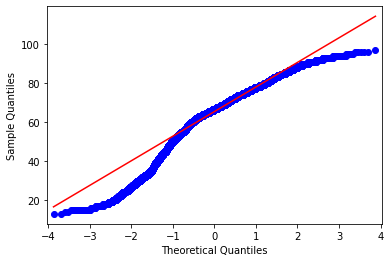

Age


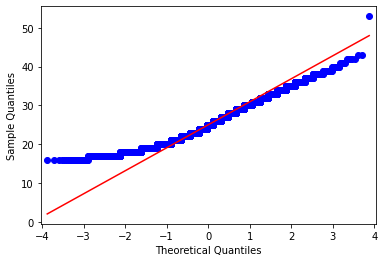

Aggression


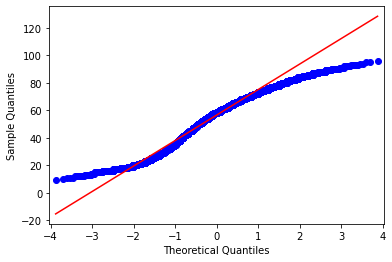

Agility


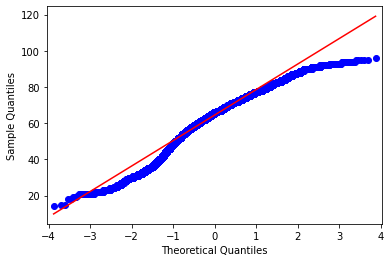

Attacking


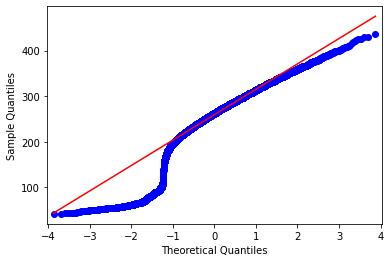

BOV


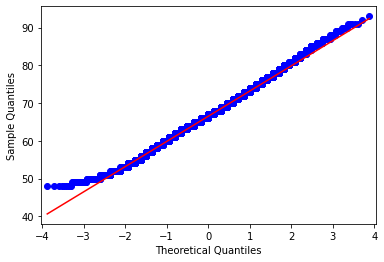

Balance


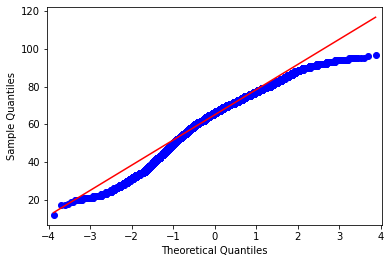

BallControl


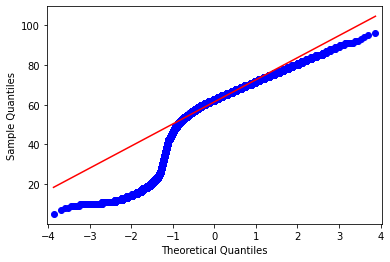

BaseStats


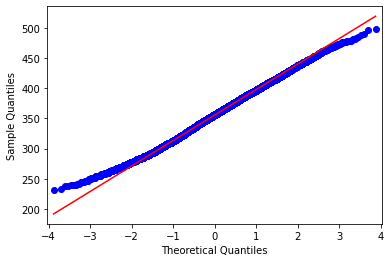

Composure


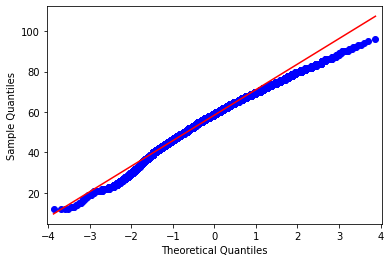

Crossing


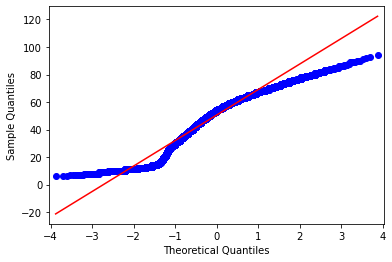

Curve


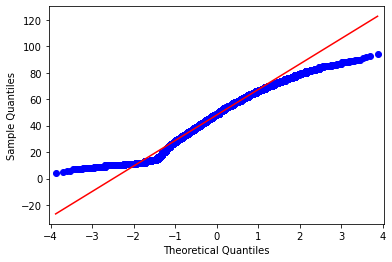

DEF


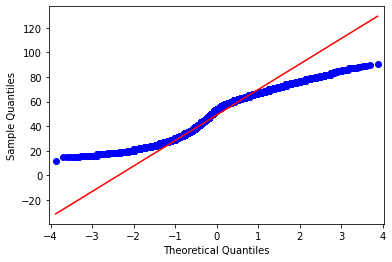

DRI


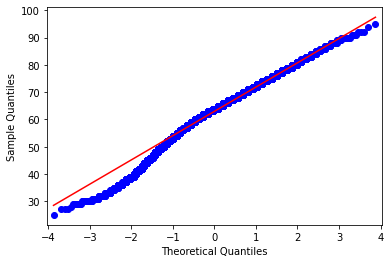

Defending


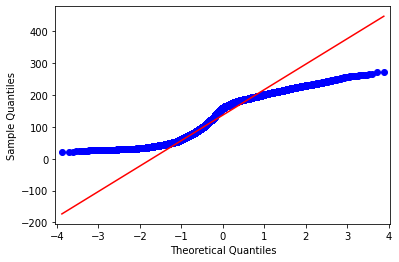

Dribbling


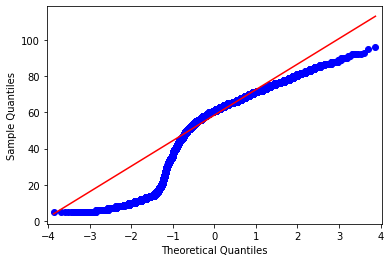

FKAccuracy


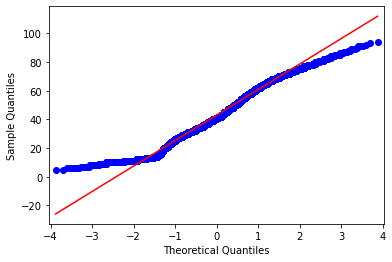

Finishing


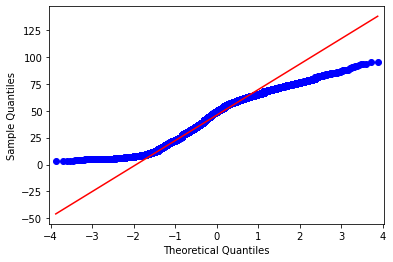

GKDiving


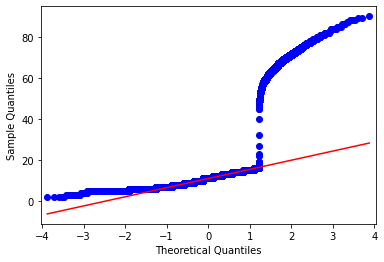

GKHandling


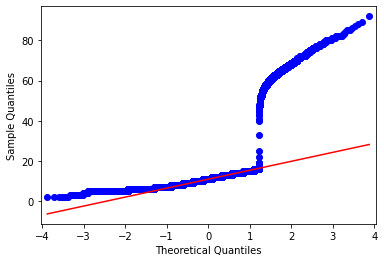

GKKicking


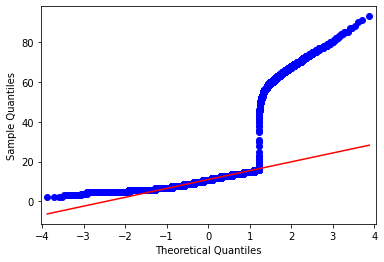

GKPositioning


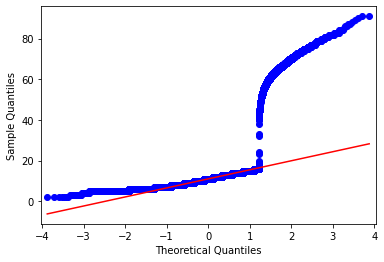

GKReflexes


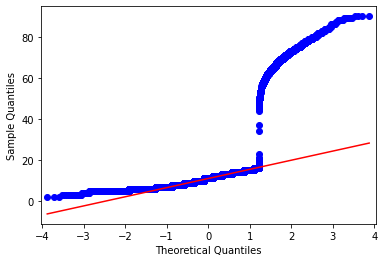

Goalkeeping


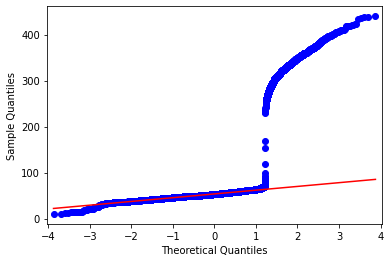

HeadingAccuracy


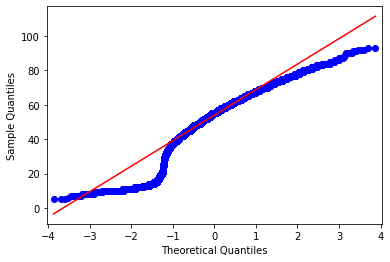

Interceptions


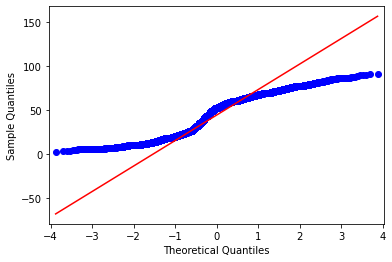

Jumping


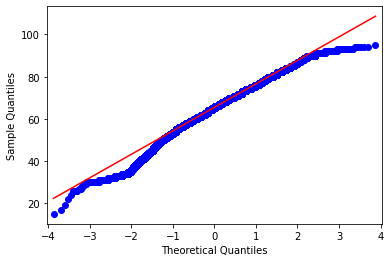

LongPassing


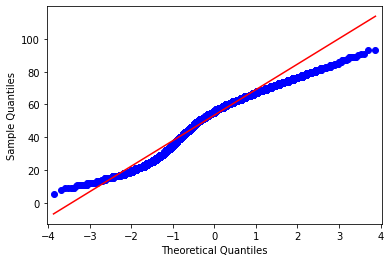

LongShots


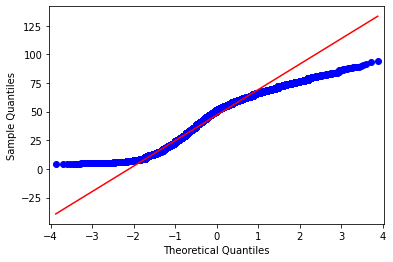

Marking


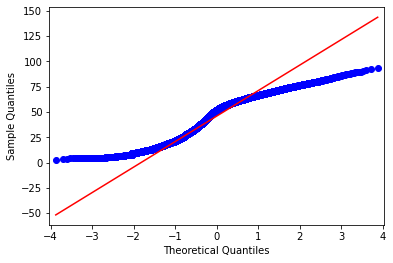

Mentality


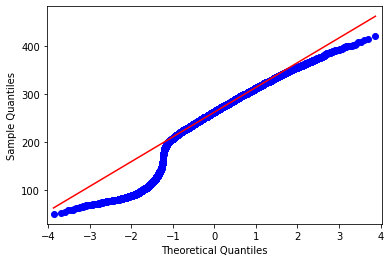

Movement


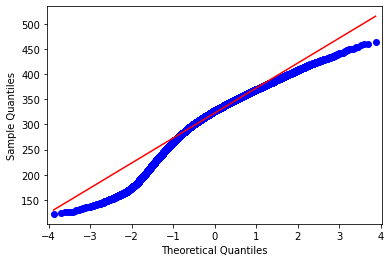

PAC


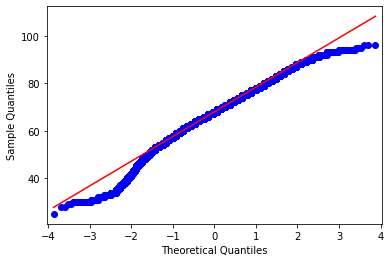

PAS


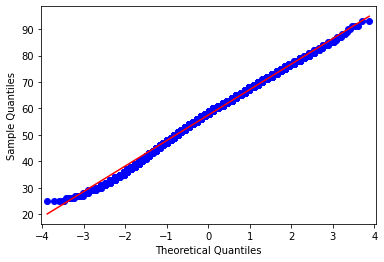

PHY


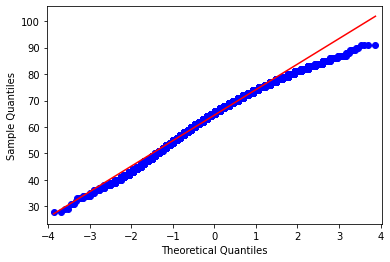

POT


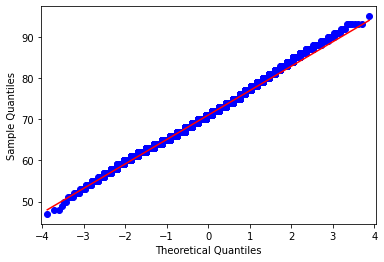

Penalties


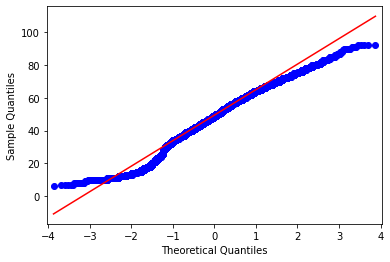

Positioning


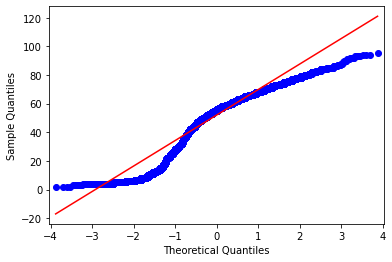

Power


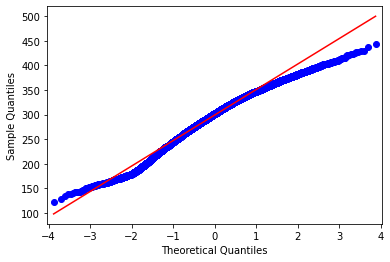

Reactions


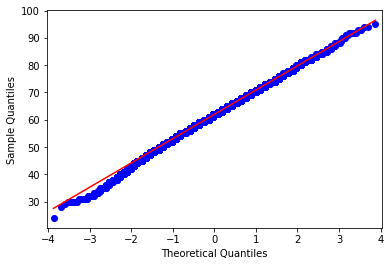

ReleaseClause


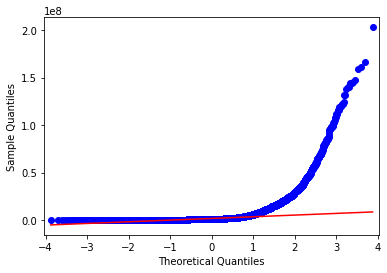

SHO


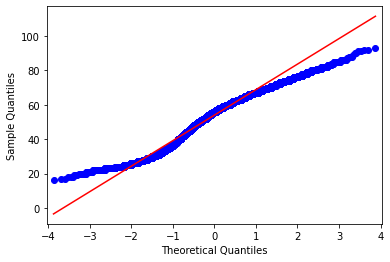

ShortPassing


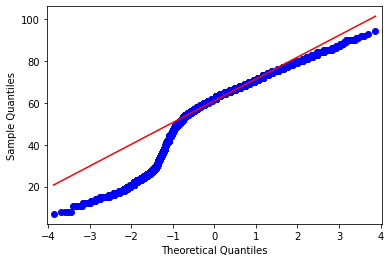

ShotPower


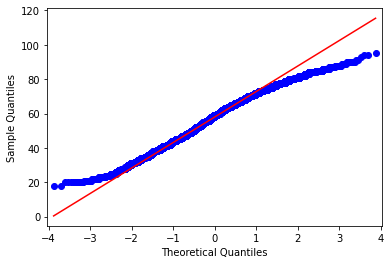

Skill


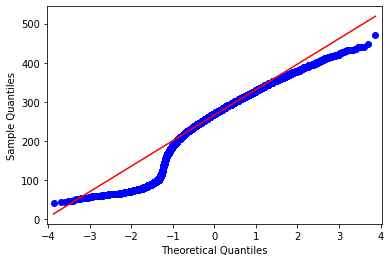

SlidingTackle


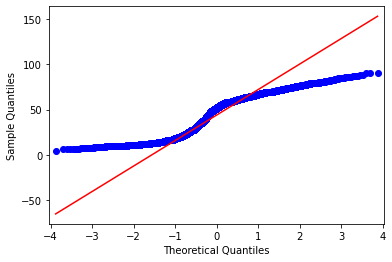

SprintSpeed


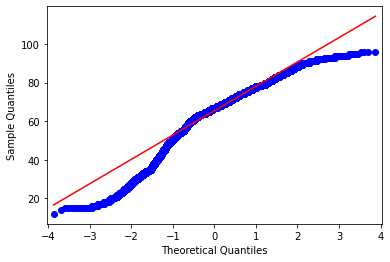

Stamina


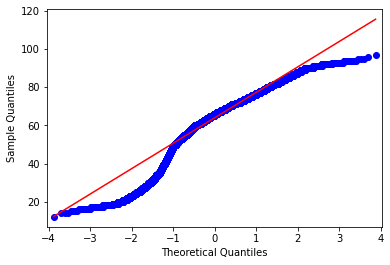

StandingTackle


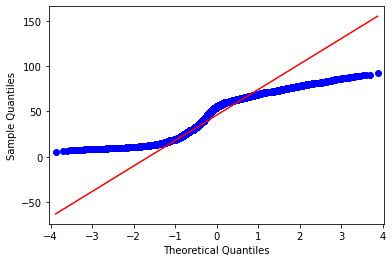

Strength


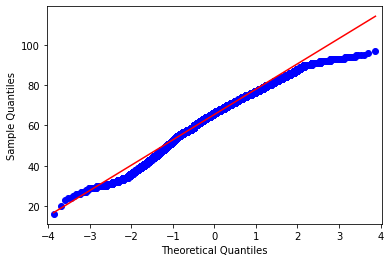

TotalStats


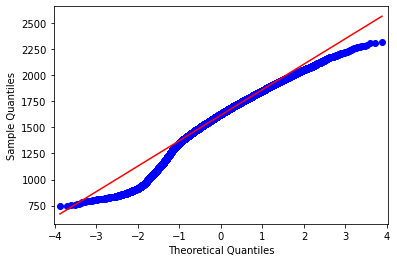

Value


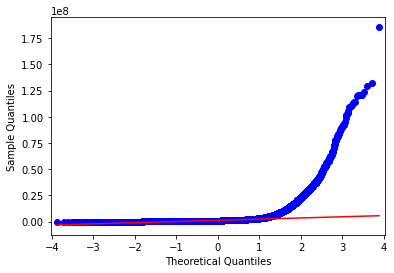

Vision


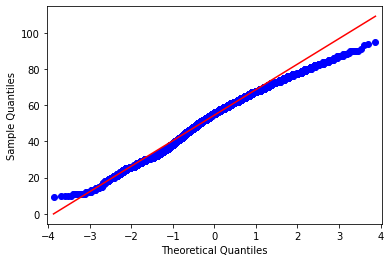

Volleys


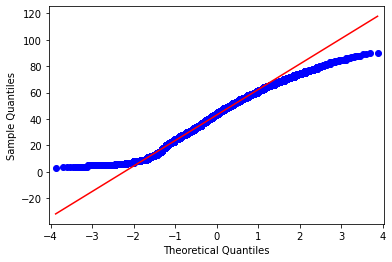

Wage


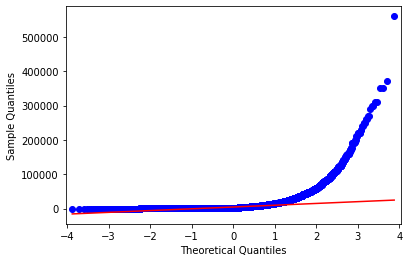

↓OVA


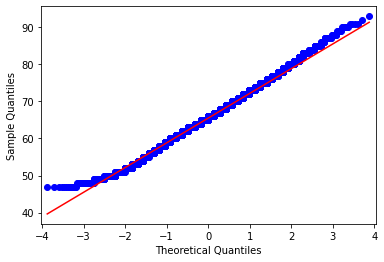

In [ ]:
# Use a for loop to create a normal Q-Q plot.
for i in new_df.loc[:,n2]:
    print(i),
    fig = sm.qqplot(new_df[i], line = 'q')
    plt.show(fig)

Acceleration


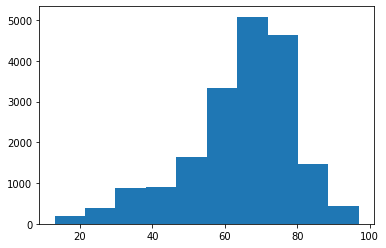

Age


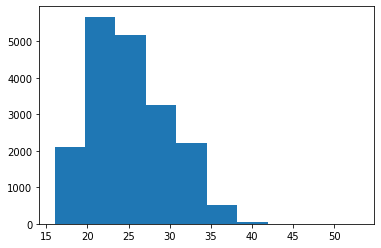

Aggression


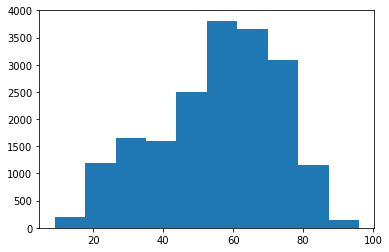

Agility


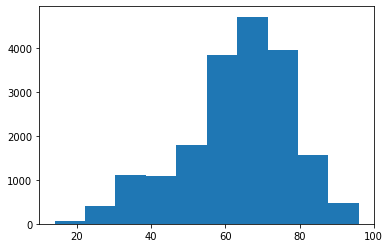

Attacking


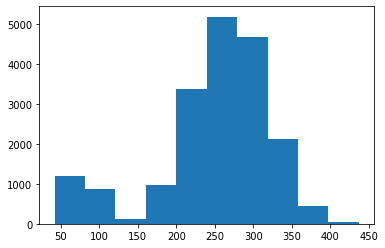

BOV


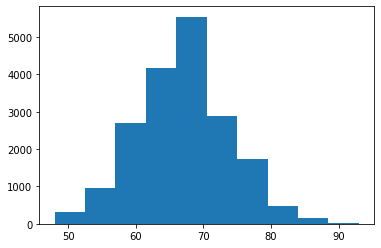

Balance


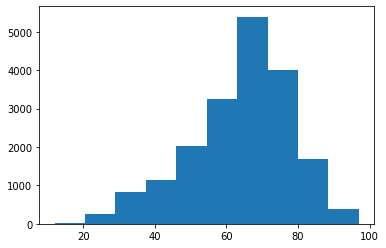

BallControl


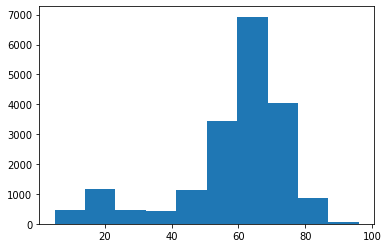

BaseStats


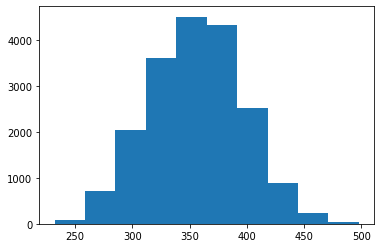

Composure


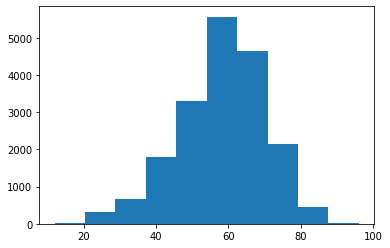

Crossing


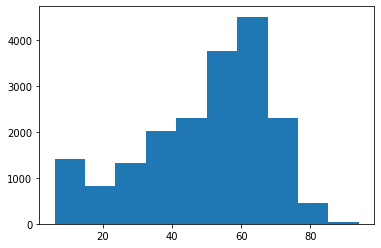

Curve


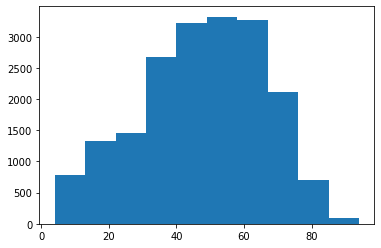

DEF


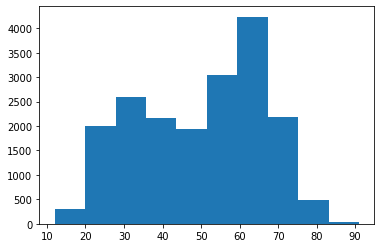

DRI


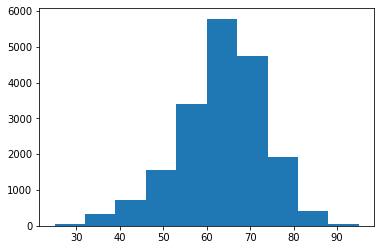

Defending


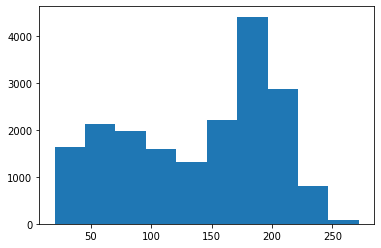

Dribbling


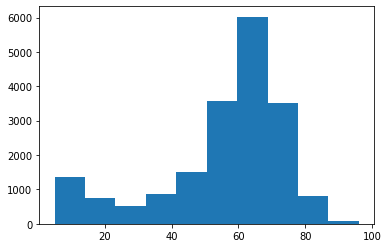

FKAccuracy


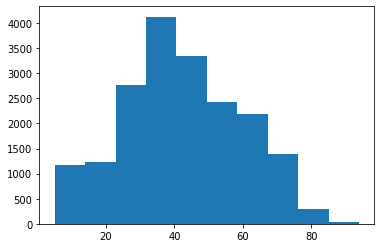

Finishing


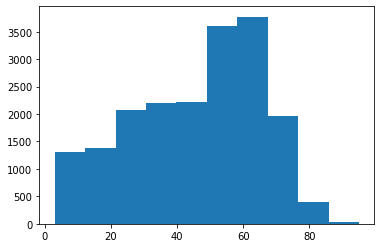

GKDiving


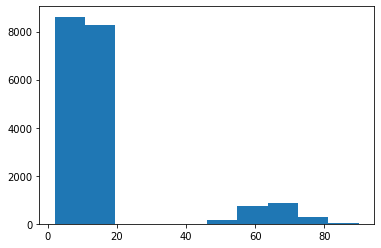

GKHandling


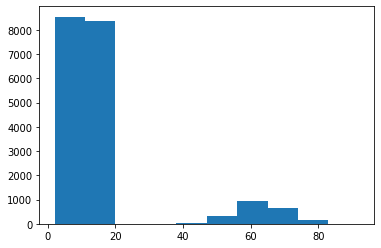

GKKicking


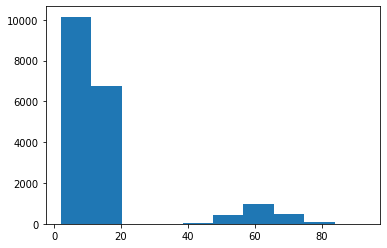

GKPositioning


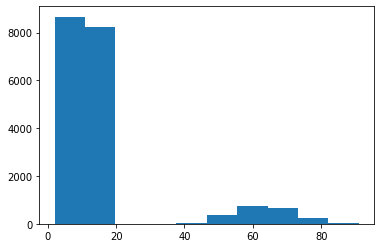

GKReflexes


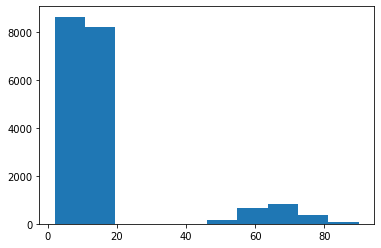

Goalkeeping


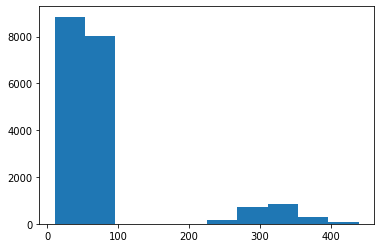

HeadingAccuracy


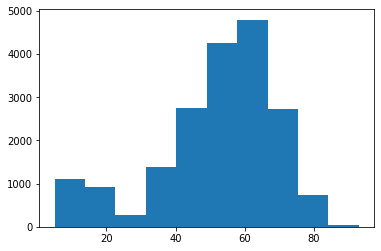

Interceptions


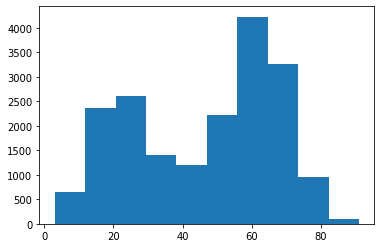

Jumping


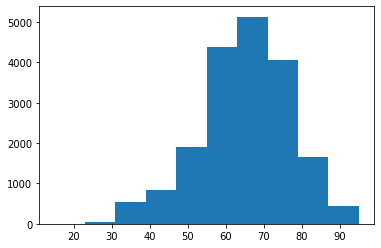

LongPassing


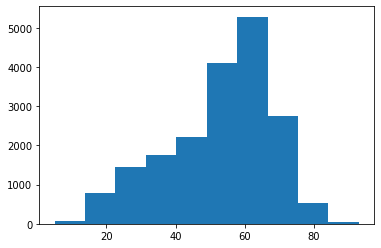

LongShots


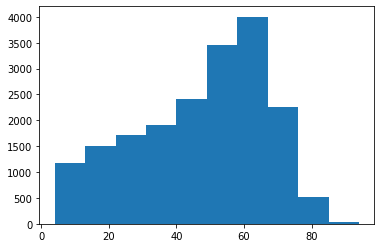

Marking


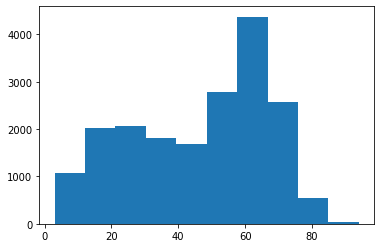

Mentality


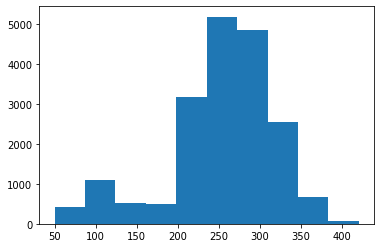

Movement


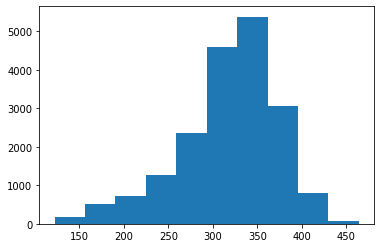

PAC


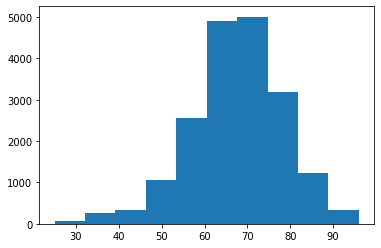

PAS


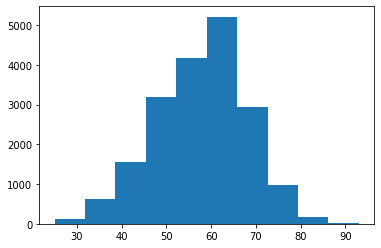

PHY


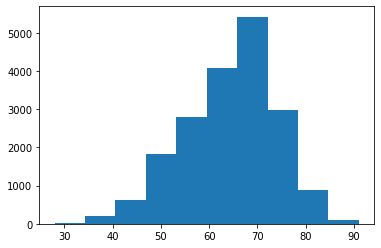

POT


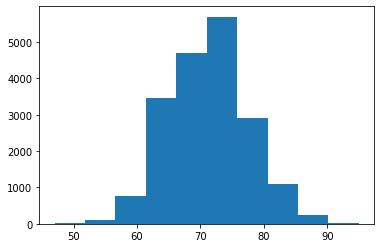

Penalties


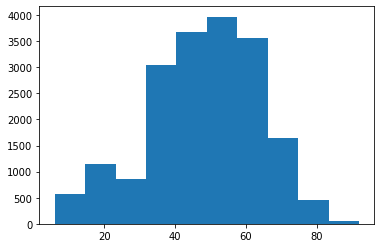

Positioning


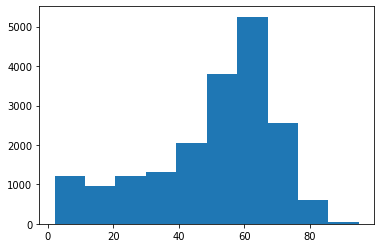

Power


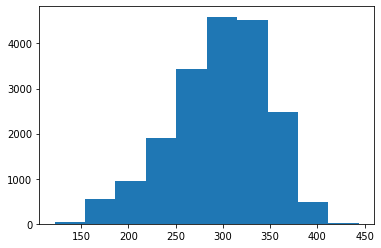

Reactions


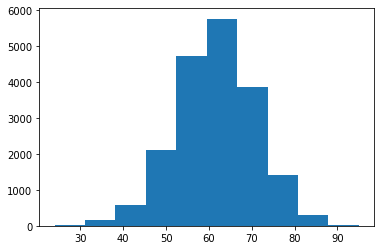

ReleaseClause


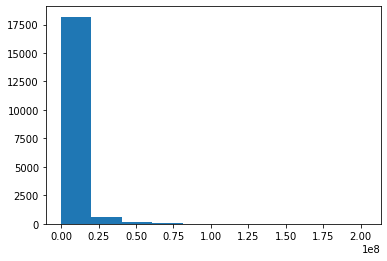

SHO


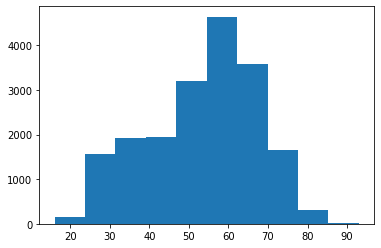

ShortPassing


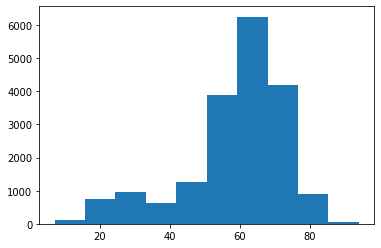

ShotPower


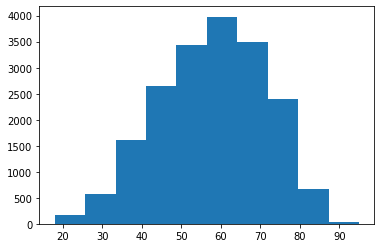

Skill


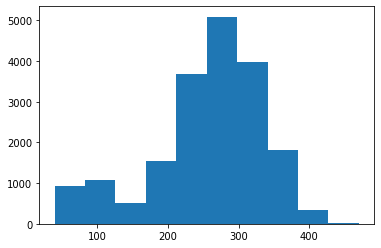

SlidingTackle


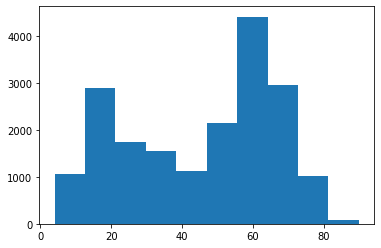

SprintSpeed


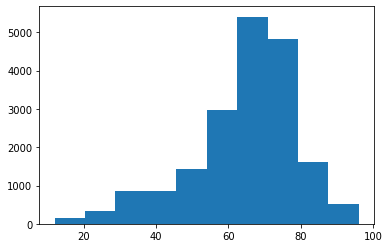

Stamina


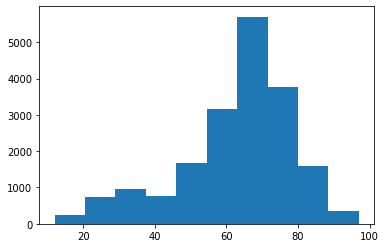

StandingTackle


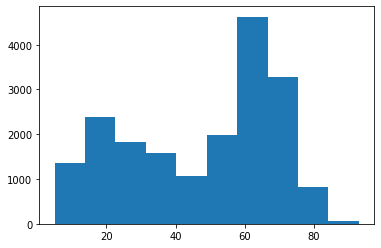

Strength


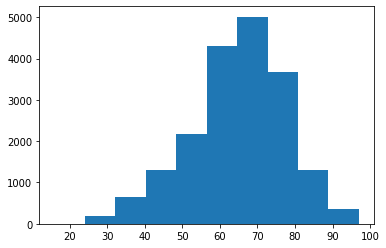

TotalStats


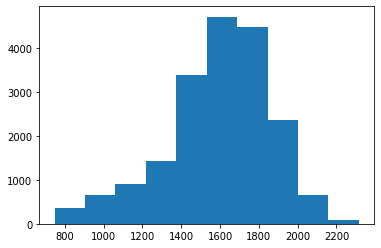

Value


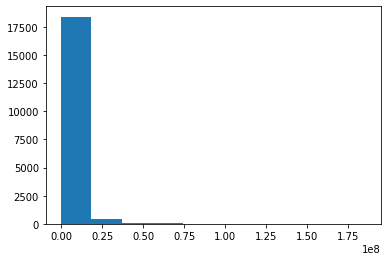

Vision


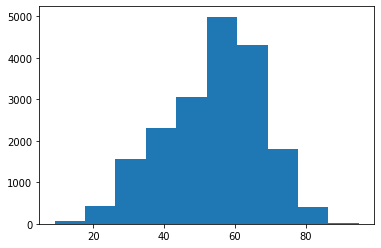

Volleys


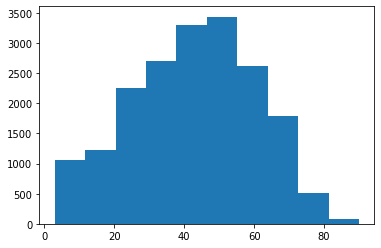

Wage


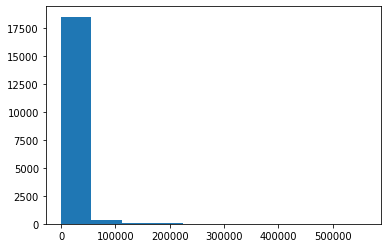

↓OVA


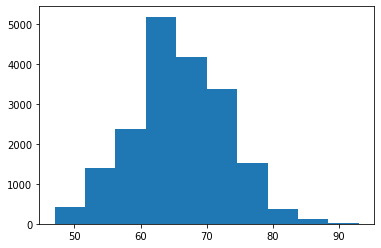

In [ ]:
# Create a histogram
for i in new_df.loc[:,n2]:
    print(i),
    fig = plt.hist(new_df[i])
    plt.show(fig)

In [ ]:
# Apply the Shapiro-Wilk approach
for i in new_df.loc[:,n2]:
        (stat, p) = stats.shapiro(new_df[i])
        print(i)
        print('statistics = %.3f, p-value = %.3f' % (stat,p))
        alpha = 0.05
        if p > alpha:
         print('(Normally distributed 😁)')
        else:
         print('(Not Normally distributed 😔 )')

Acceleration
statistics = 0.949, p-value = 0.000
(Not Normally distributed 😔 )
Age
statistics = 0.974, p-value = 0.000
(Not Normally distributed 😔 )
Aggression
statistics = 0.971, p-value = 0.000
(Not Normally distributed 😔 )
Agility
statistics = 0.967, p-value = 0.000
(Not Normally distributed 😔 )
Attacking
statistics = 0.903, p-value = 0.000
(Not Normally distributed 😔 )
BOV
statistics = 0.996, p-value = 0.000
(Not Normally distributed 😔 )
Balance
statistics = 0.972, p-value = 0.000
(Not Normally distributed 😔 )
BallControl
statistics = 0.858, p-value = 0.000
(Not Normally distributed 😔 )
BaseStats
statistics = 0.998, p-value = 0.000
(Not Normally distributed 😔 )
Composure
statistics = 0.988, p-value = 0.000
(Not Normally distributed 😔 )
Crossing
statistics = 0.946, p-value = 0.000
(Not Normally distributed 😔 )
Curve
statistics = 0.979, p-value = 0.000
(Not Normally distributed 😔 )
DEF
statistics = 0.955, p-value = 0.000
(Not Normally distributed 😔 )
DRI
statistics = 0.982, p-value =

**Inferential Statistics**

In [ ]:
# The normally distributed variables are as follows: BOV,BaseStats,PAS,PHY,POT,Reactions,and OVA.
# Run two sample t-test to determine if there is any significant differrence in the left and right foot of the players associated with BOV,BaseStats,PAS,PHY,POT,Reactions,and OVA
# Create two groups that is L and R.
new_df1 = new_df.loc[:,['BOV','BaseStats','PAS','PHY','POT','Reactions','↓OVA','PreferredFoot']]
L = new_df1[new_df1['PreferredFoot'] == 'Left']
R = new_df1[new_df1['PreferredFoot'] == 'Right']
L = L.drop('PreferredFoot', axis = 1)
R = R.drop('PreferredFoot', axis = 1)

# Run two sample t-test
test = stats.ttest_ind(a = L, b = R, equal_var=True)

# Create a data frame named new_df2.
test_df = pd.DataFrame(test)
test_df.rename(columns = {0 : "BOV",1:'BaseStats',2:'PAS',3:'PHY',4:'POT',5:'Reactions',6:'↓OVA'},
               index = {0:"Statistics",1:"P-value"} ,inplace = True)
test_df

,BOV,BaseStats,PAS,PHY,POT,Reactions,↓OVA
Statistics,5.402370e+00,7.253725e+00,8.234451e+00,-4.096620,5.718895e+00,2.110073,6.503870e+00
P-value,6.655803e-08,4.210720e-13,1.919578e-16,0.000042,1.088316e-08,0.034865,8.023222e-11


Hypotheses testing:

H0: There is no significant difference between the means of both groups.

vs.

H1: There is a statistically significant difference between the means of both groups.

I ran a two sample t-test and determined that there is a statistically significant difference between the means of both groups. So, the players played in fifa2021 with left foot and right foot have had a significant difference in their overall performance.

In [ ]:
# Run non-parametric test that is wilcoxon rank sum test on non-normally distributed variables.

new_df2 = new_df.drop(['BOV','BaseStats','PAS','PHY','POT','Reactions','↓OVA'], axis = 1) # Drop normally distributed variables
L = new_df2[new_df2['PreferredFoot'] == 'Left']
R = new_df2[new_df2['PreferredFoot'] == 'Right']
L = L.drop(n1, axis = 1) # Drop categorical variables
R = R.drop(n1, axis = 1) # Drop categorical variables
L = L.drop('Joined', axis = 1) # Drop datetime variables
R = R.drop('Joined', axis = 1) # Drop datetime variables

# Run a non-parametric test: Wilcoxon rank sum test on non-normally distributed variables.
ranksums(L,R)

RanksumsResult(statistic=8581.112241582026, pvalue=0.0)

Hypotheses testing:

H0: m1 = m2

Vs.

H1: m1 != m2

Here, I applied wilcoxon rank-sum test. I found that the p-value is statistically significant that is less than alpha value 0.05. Therefore, I deduced that there are sufficient evidence to reject the null hypothesis. Hence, the population medians are statistically significantly different from each other.

In [ ]:
# Drop name variable
d1 = new_df.loc[:,n1].drop(['BestPosition', 'Club','IR' , 'Nationality','Positions'], axis = 1)
d1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18979 entries, 0 to 898
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   A/W              18979 non-null  object
 1   Contract_Status  18979 non-null  object
 2   D/W              18979 non-null  object
 3   Name             18979 non-null  object
 4   PreferredFoot    18979 non-null  object
 5   SM               18979 non-null  object
 6   W/F              18979 non-null  object
dtypes: object(7)
memory usage: 1.2+ MB


In [ ]:
# Run a chi-Squared test forr independence on the categorical variables.
def chitest(df,tab):
   out = []
   for i in tab:
     a = pd.crosstab(df[i] ,df['PreferredFoot'])
     c, p, dof, expected = chi2_contingency(a) # Apply chi2_contingency on crosstab
     out.append(p)
   return(out)

chi = chitest(new_df,d1)
chi_test = pd.DataFrame(chi)
chi_test = chi_test.drop([3,6], axis =0)
chi_test = chi_test.rename(columns = {0:'P-value'}, index = {0:'A/W',1:"Contract Status",2:'D/W',4:'SM',5:'W/F'})
chi_test

,P-value
A/W,1.552063e-15
Contract Status,1.288194e-03
D/W,3.397274e-06
SM,0.000000e+00
W/F,3.632371e-54


In [ ]:
# Apply Fisher exact test on BestPosition, Club,IR , Name, Nationality, and Positions
#p = fisher_exact(table, alternative='two-sided')
d2 = new_df.loc[:,n1].drop(['A/W', 'Contract_Status','D/W' , 'SM', 'W/F','Name'], axis = 1)
d2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18979 entries, 0 to 898
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   BestPosition   18979 non-null  object
 1   Club           18979 non-null  object
 2   IR             18979 non-null  object
 3   Nationality    18979 non-null  object
 4   Positions      18979 non-null  object
 5   PreferredFoot  18979 non-null  object
dtypes: object(6)
memory usage: 1.0+ MB


In [ ]:
# Apply fisher-exact test
def fishtest(df,tab):
   out = []
   for i in tab:
     a = pd.crosstab(df[i] ,df['PreferredFoot'])
     c, p, dof, expected = chi2_contingency(a) # chi2_contingency is closest to fisher exact test in python
     out.append(p)
   return(out)

fish = fishtest(new_df,d2)
fish_test = pd.DataFrame(fish)
fish_test = fish_test.drop([5], axis =0)
fish_test = fish_test.rename(columns = {0:'P-value'}, index = {0:'BestPosition',1:"Club",2:'IR',3:'Nationality',4:'Positions'})
fish_test

# Note:- Python does not have a function which accepts more than 2 rows in a contingency table. So, the stats.fisher exact test does not work on more than 2 rows. The chi2_contingency is the closest option in python.

,P-value
BestPosition,0.000000
Club,0.999995
IR,0.967786
Nationality,0.000004
Positions,0.000000


In [ ]:
# Merge two data frames
new = [chi_test,fish_test]
df2 = pd.concat(new)
df2

,P-value
A/W,1.552063e-15
Contract Status,1.288194e-03
D/W,3.397274e-06
SM,0.000000e+00
W/F,3.632371e-54
BestPosition,0.000000e+00
Club,9.999953e-01
IR,9.677858e-01
Nationality,4.182274e-06
Positions,0.000000e+00


In [ ]:
#  Create a correlation matrix
spear_vars = new_df.drop(['BOV','BaseStats','PAS','PHY','POT','Reactions','↓OVA'], axis = 1) # Drop normally distributed variables
pear_vars = new_df.drop(spear_vars, axis = 1)

# Create a spearman rank correlation matrix
spear_vars.corr(method = 'spearman').round(2)

,Acceleration,Age,Aggression,Agility,Attacking,Balance,BallControl,Composure,Crossing,Curve,...,SprintSpeed,Stamina,StandingTackle,Strength,TotalStats,Value,Vision,Volleys,Wage,Weight
Acceleration,1.00,-0.11,0.12,0.81,0.52,0.67,0.54,0.31,0.61,0.56,...,0.91,0.46,0.06,-0.22,0.54,0.33,0.43,0.51,0.18,-0.48
Age,-0.11,1.00,0.30,0.02,0.27,-0.07,0.20,0.40,0.20,0.18,...,-0.10,0.23,0.16,0.37,0.33,0.09,0.23,0.16,0.31,0.24
Aggression,0.12,0.30,1.00,0.15,0.39,0.11,0.41,0.52,0.37,0.32,...,0.15,0.58,0.73,0.51,0.60,0.36,0.27,0.24,0.35,0.09
Agility,0.81,0.02,0.15,1.00,0.60,0.75,0.64,0.43,0.66,0.66,...,0.73,0.47,0.07,-0.25,0.64,0.36,0.59,0.59,0.24,-0.53
Attacking,0.52,0.27,0.39,0.60,1.00,0.47,0.87,0.72,0.78,0.83,...,0.51,0.55,0.19,0.14,0.88,0.56,0.77,0.90,0.49,-0.19
Balance,0.67,-0.07,0.11,0.75,0.47,1.00,0.53,0.31,0.58,0.57,...,0.58,0.37,0.10,-0.40,0.52,0.21,0.49,0.48,0.13,-0.66
BallControl,0.54,0.20,0.41,0.64,0.87,0.53,1.00,0.74,0.77,0.80,...,0.51,0.57,0.30,0.08,0.87,0.65,0.78,0.75,0.52,-0.26
Composure,0.31,0.40,0.52,0.43,0.72,0.31,0.74,1.00,0.58,0.64,...,0.30,0.52,0.38,0.30,0.78,0.63,0.67,0.59,0.59,-0.03
Crossing,0.61,0.20,0.37,0.66,0.78,0.58,0.77,0.58,1.00,0.79,...,0.58,0.57,0.36,-0.05,0.82,0.47,0.67,0.61,0.39,-0.36
Curve,0.56,0.18,0.32,0.66,0.83,0.57,0.80,0.64,0.79,1.00,...,0.52,0.50,0.21,-0.04,0.82,0.44,0.75,0.78,0.38,-0.32


In [ ]:
# Create a pearson correlation matrix
pear_vars.corr(method = 'pearson').round(2) # Normally distributed variables

,BOV,BaseStats,PAS,PHY,POT,Reactions,↓OVA
BOV,1.00,0.84,0.69,0.57,0.67,0.87,0.99
BaseStats,0.84,1.00,0.86,0.50,0.52,0.75,0.85
PAS,0.69,0.86,1.00,0.20,0.43,0.62,0.70
PHY,0.57,0.50,0.20,1.00,0.21,0.52,0.57
POT,0.67,0.52,0.43,0.21,1.00,0.51,0.63
Reactions,0.87,0.75,0.62,0.52,0.51,1.00,0.87
↓OVA,0.99,0.85,0.70,0.57,0.63,0.87,1.00


In [ ]:
# Run a spearman rank correlation test
New_df = new_df.drop(n1, axis = 1)
New_df = New_df.drop('Joined', axis = 1)

New_df = New_df.drop(pear_vars, axis = 1)

# Define a function named corr.
def spear_corr(df):
  out = []
  for i in df.loc[:,]:
   x = df[i]
   y = df['Age']
   cor = spearmanr(x,y)
   out.append(cor)
  return(out)

# Call a previosly created function corr.
cor_var = pd.DataFrame(spear_corr(New_df))


#new_df.select_dtypes(include = 'object').columns
dat = pd.DataFrame([i for i in New_df.loc[:,]])
cor_var = cor_var.rename(columns = {0:"Corr. Coef.",1 :"P-value"}, index = dat[0])
cor_var

,correlation,pvalue
Acceleration,-0.110136,2.683520e-52
Age,1.000000,0.000000e+00
Aggression,0.295383,0.000000e+00
Agility,0.018870,9.330809e-03
Attacking,0.272618,0.000000e+00
Balance,-0.065125,2.686603e-19
BallControl,0.202475,9.097965e-175
Composure,0.395936,0.000000e+00
Crossing,0.197902,6.720309e-167
Curve,0.180256,2.450301e-138


Hypotheses Testing:

H0: There is no monotonic relationship between the two variables in the population.

vs.

H1: There exist a monotonic relationship between the two variables in the population.

In [ ]:
# Run a pearson correlation test
New_df = new_df.drop(n1, axis = 1)
New_df = new_df.drop('Joined', axis = 1)

New_df = new_df.drop(spear_vars, axis = 1)

# Define a function named corr.
def spear_corr(df):
  out = []
  for i in df.loc[:,]:
   x = df[i]
   y = df['BaseStats']
   cor = pearsonr(x,y)
   out.append(cor)
  return(out)

# Call a previosly created function corr.
cor_var = pd.DataFrame(spear_corr(New_df))


#new_df.select_dtypes(include = 'object').columns
dat = pd.DataFrame([i for i in New_df.loc[:,]])
cor_var = cor_var.rename(columns = {0:"Corr. Coef.",1 :"P-value"}, index = dat[0])
cor_var

,Corr. Coef.,P-value
BOV,0.841199,0.0
BaseStats,1.000000,0.0
PAS,0.858542,0.0
PHY,0.502501,0.0
POT,0.520473,0.0
Reactions,0.751708,0.0
↓OVA,0.845894,0.0





Hypotheses Testing:

H0: There exist no correlation between two variables.

vs.

H1: There exist a correlation between two variables.

# Exploratory Data Analysis (EDA)

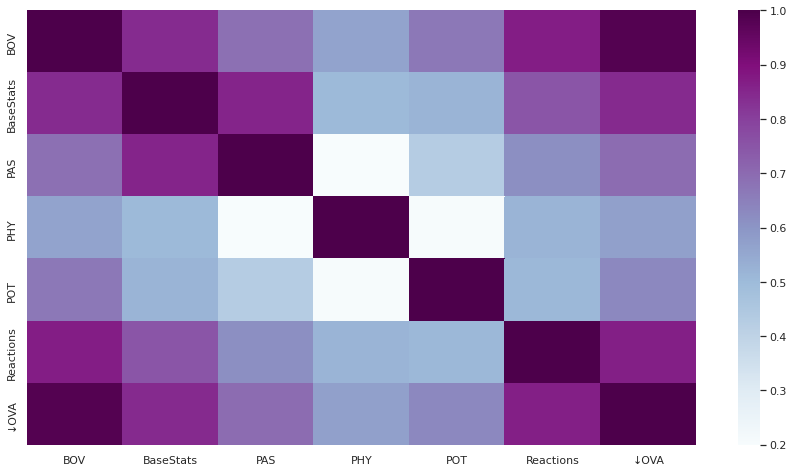

In [ ]:
# plot the Pearson correlations among the variables
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(pear_vars.corr(method = 'pearson'),cmap="BuPu")
plt.show()

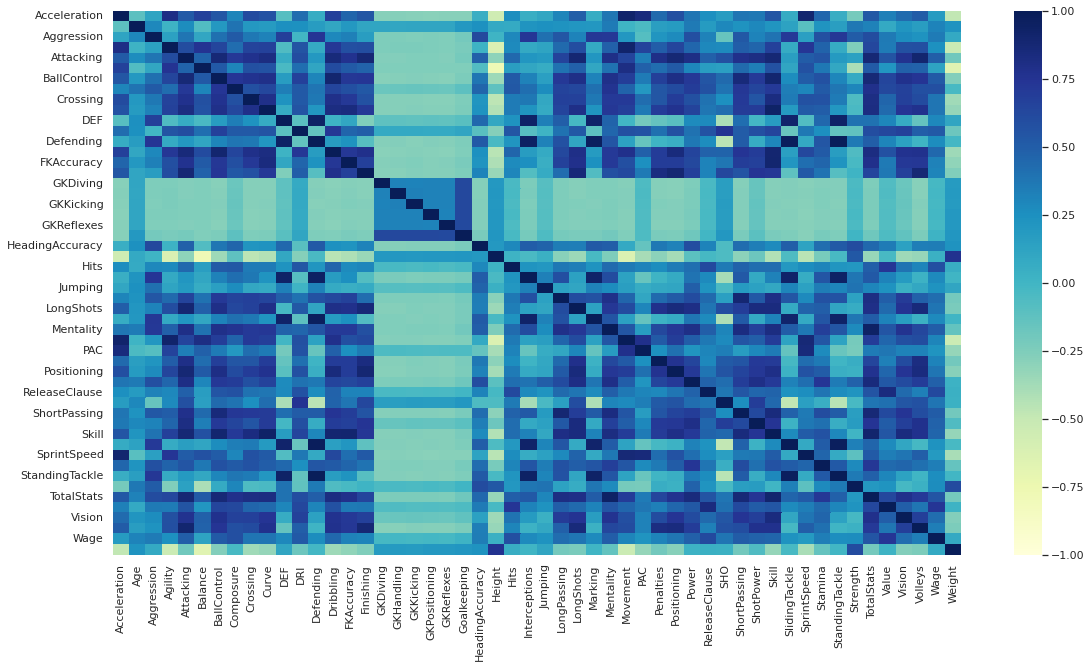

In [ ]:
# plot the Spearman rank correlations among the variables
sns.set(rc = {'figure.figsize':(19,10)})
# Generate a mask to onlyshow the bottom triangle
#mask = np.triu(np.ones_like(spear_vars.corr(method = 'spearman'), dtype=bool))

sns.heatmap(spear_vars.corr(method = 'spearman'),cmap="YlGnBu", vmin=-1, vmax=1)
plt.show()

In [ ]:
# Plot scatter plot matrix
#sns.pairplot(new_df.loc[:,n2])

**Anamolies Detection**

In [ ]:
# Anamolies/Outliers detection
# Create a function to determine anamolies in the data set
def outlier(df,col):
  q1 = df[col].quantile(0.25)
  q3 = df[col].quantile(0.75)
  IQR = q3 - q1
  lower_limit = q1 - (1.5*IQR)
  upper_limit = q3 + (1.5*IQR)
  upper_lower_limit_outliers = ((df[col] <= lower_limit) | (df[col] >= upper_limit)).tolist()
  total_outliers = [i for i,x in enumerate(upper_lower_limit_outliers) if x]
  return(total_outliers)

In [ ]:
# Run a for loop to detect anamolies in each column.
output = []
for col in new_df.loc[:,n2]:
    if new_df[col].dtype in ["int64","float64"]:
         a = outlier(new_df.loc[:,n2],col)
         output.extend(a)

# Print indices contain outliers
print(f'Outliers Indices: {output}')
# Print distinct indices with number of outliers
print(f'Total Number of outliers:\n{pd.Index(new_df.loc[output,].index).value_counts()}')

Outliers Indices: [516, 600, 748, 802, 887, 1000, 1217, 1330, 1333, 1400, 1492, 1504, 1534, 1540, 1620, 1632, 1843, 1976, 1985, 2123, 2235, 2236, 2244, 2315, 2332, 2376, 2388, 2476, 2567, 2573, 2681, 2696, 2734, 2753, 2757, 2764, 2838, 2848, 2851, 2863, 2897, 2918, 2929, 2971, 2979, 3170, 3190, 3303, 3308, 3503, 3576, 3595, 3627, 3675, 3724, 3799, 3941, 4065, 4179, 4266, 4297, 4319, 4329, 4380, 4443, 4519, 4526, 4527, 4532, 4533, 4583, 4624, 4688, 4689, 4775, 4780, 4783, 4799, 4923, 4937, 4992, 4999, 5053, 5073, 5120, 5136, 5162, 5183, 5220, 5295, 5320, 5413, 5430, 5455, 5472, 5488, 5520, 5594, 5608, 5655, 5692, 5794, 5855, 5924, 5934, 6033, 6080, 6122, 6169, 6225, 6280, 6295, 6324, 6369, 6406, 6436, 6525, 6528, 6549, 6590, 6749, 6768, 6822, 6839, 6856, 6860, 6919, 6956, 6959, 6979, 6990, 6993, 7003, 7020, 7027, 7051, 7095, 7113, 7118, 7162, 7204, 7378, 7502, 7547, 7655, 7679, 7683, 7725, 7762, 7769, 7896, 7921, 7980, 7992, 7995, 8196, 8203, 8234, 8242, 8345, 8412, 8444, 8506, 8553, 86

In [ ]:
# Drop outliers and create a new data frame named new_df.
new_Df = new_df.drop(output, axis = 0)

In [ ]:
#  Print the old and new shape
print(f'Old shape{new_df.shape}')
print(f'New shape{new_Df.shape}')

Old shape(18979, 72)
New shape(12371, 72)


In [ ]:
# Determine na values in the new data frame.
new_Df.isna().sum().value_counts()

0    72
dtype: int64

In [ ]:
# Assigning numeric values to all categorical variables
for i in new_Df.loc[:,n1]:
  new_Df[i] = new_Df[i].astype('category')
  new_Df[i] = new_Df[i].cat.codes

**Check Multicollinearity**

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

a = new_Df[[i for i in new_Df.loc[:,]]]
a = a.drop('Joined',axis = 1)
a = a.astype('float64')
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["Feature"] = a.columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(a.values, i)
                          for i in range(len(a.columns))]

# Create a data frame without higly correlated variables for the logistic regression.
log_Data = vif_data[vif_data['VIF'] <= 5]
print(vif_data[vif_data['VIF'] >= 5])
print(log_Data)

         Feature          VIF
1   Acceleration          inf
2            Age   159.989743
3     Aggression          inf
4        Agility          inf
5      Attacking          inf
..           ...          ...
65        Vision          inf
66       Volleys          inf
67           W/F    11.454322
69        Weight   366.690607
70          ↓OVA  6142.711035

[63 rows x 2 columns]
          Feature       VIF
0             A/W  4.534655
11           Club  4.033065
31           Hits  1.092942
32             IR  1.146951
40           Name  4.024565
41    Nationality  3.729436
50  PreferredFoot  4.720102
68           Wage  2.730495


**Feature Selection techniques**

* Recursive feature ellimination (RFE) and Forward stepwise selection methods

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# Define the variables X and y.
j = new_Df.drop(['PreferredFoot','Joined'], axis = 1)
k = new_Df['PreferredFoot']

mod = LogisticRegression()

# Fit a model
rfe = RFE(mod,step = 10)
Fit = rfe.fit(j,k)

# Define a variables called rank, names, and Feature.
rank = pd.DataFrame(Fit.ranking_)
names = pd.DataFrame(new_Df.columns)
Feature = pd.DataFrame(Fit.support_)

# Create a dataframe called dat.
dat = pd.concat([names, rank,Feature], axis = 1)
dat.columns = ['Features','Rank','Selected Features']

# Filter a dat dataframe.
dat = dat[dat['Selected Features']== True]

print("Number of Selected Features: %d" % Fit.n_features_)
dat.reset_index()
dat = dat.Features

Number of Selected Features: 35


**ExtraTreesClassifier**

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
clf = ExtraTreesClassifier(n_estimators = 5,
                                        criterion ='entropy', max_features = 30)
clf = clf.fit(j, k)
Feature = clf.feature_importances_
model = SelectFromModel(clf, prefit=True)
X_new = model.transform(j)
print(X_new.shape)
print(f'Number of Selected Features:{len(Feature)}')


(12371, 9)
Number of Selected Features:70


In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
BestFeatures = SelectKBest(score_func=chi2, k=10)
fit = BestFeatures.fit(j,k)

df_scores = pd.DataFrame(fit.scores_)
df_columns = pd.DataFrame(j.columns)
f_Scores = pd.concat([df_columns,df_scores],axis=1)
f_Scores.columns = ['Specs','Score']
new_Dat = f_Scores.nlargest(30,'Score')
new_Dat

,Specs,Score
63,Value,1.765464e+07
51,ReleaseClause,1.051051e+07
67,Wage,8.512340e+04
40,Name,1.299011e+04
28,Goalkeeping,1.179010e+04
48,Positions,8.620576e+03
62,TotalStats,6.167813e+03
19,Defending,5.355569e+03
56,Skill,4.704530e+03
14,Crossing,3.040621e+03


**XGBoost technique**

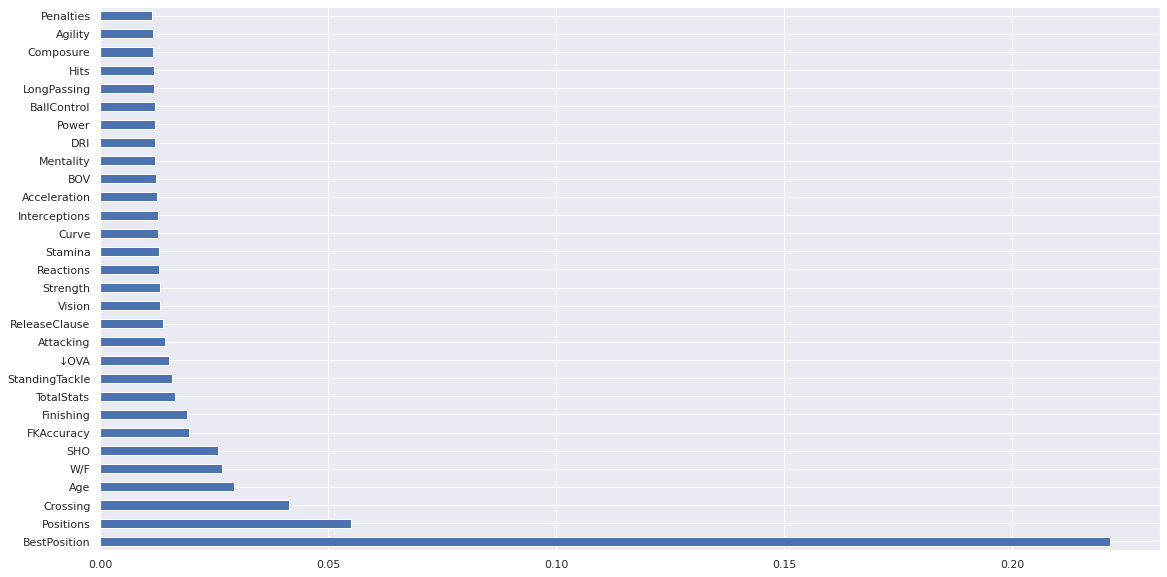

<Figure size 576x432 with 0 Axes>

,Feature importance value
BestPosition,0.221448
Positions,0.055025
Crossing,0.041474
Age,0.029421
W/F,0.026767
SHO,0.025866
FKAccuracy,0.019529
Finishing,0.019132
TotalStats,0.016520
StandingTackle,0.015769


In [ ]:
import xgboost
model = xgboost.XGBClassifier()
model.fit(j,k)

# XGBoost - Extreme gradient boosting decision tree
# plot the graph of feature importances for better visualization
feat_imp = pd.Series(model.feature_importances_, index=j.columns)
feat_imp.nlargest(30).plot(kind='barh')

plt.figure(figsize=(8,6))
plt.show()
new_dat = feat_imp.nlargest(30)
new_dat = pd.DataFrame(new_dat)
new_dat.rename(columns={0:"Feature importance value"})

In [ ]:
nnew_df = new_Df[dat]

**Machine Learning Models**
* Apply the logistic regression, PCA, SVM, Random Forest, and Decision Trees
* Use the validation set approach, split the data into train and test set.

In [ ]:
# Apply the validation set approach
y = new_Df.PreferredFoot
x = nnew_df.drop(['Joined'], axis = 1)

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.2, random_state = 123)
print(f'x_train shape: {x_train.shape},y_train shape: {y_train.shape}')
print(f'x_test shape: {x_test.shape},y_test shape: {y_test.shape}')

x_train shape: (9896, 34),y_train shape: (9896,)
x_test shape: (2475, 34),y_test shape: (2475,)


**Logistic Regression**

In [ ]:
# Predict how well the player will play with given IR rating and best position using the logistic regression.
from sklearn.linear_model import LogisticRegression as lg
from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
xtrain = sc_x.fit_transform(x_train)
xtest = sc_x.transform(x_test)
log_mod = lg()

# Fit the model
fit = log_mod.fit(xtrain,y_train)

# Predict the model performance on an unseen data set/test set
log_predict = log_mod.predict(xtest)

# Evaluate rf models prediction
rf_accuracy = accuracy_score(y_test,log_predict)
print('Accuracy: %.3f' % rf_accuracy)

Accuracy: 0.790


**Random Forest**

In [ ]:
# Fit the random forest (RF) model on x_train and y_train
# Predict the RF models performance on x_test
# Evaluate the RF models prediction on y_test
rf_model = RandomForestClassifier(random_state = 1)
rf_model.fit(x_train,y_train)

# Predict the model performance on an unseen data set/test set
rf_predict = rf_model.predict(x_test)

# Evaluate rf models prediction
rf_accuracy = accuracy_score(y_test,rf_predict)
print('Accuracy: %.3f' % rf_accuracy)

Accuracy: 0.859


**Decision Tree**

In [ ]:
# Fit the decision tree model
dt_model = tree.DecisionTreeClassifier(max_depth = 4,random_state=1)# max_Depth defines the number of levels in the decision tree
dt_model_fit = dt_model.fit(x_train,y_train)

# Predict the dt models performance on the test set/validation set
dt_predict = dt_model.predict(x_test)

# Evaluate the dt models prediction
dt_accuracy = accuracy_score(y_test,dt_predict)
print('Accuracy: %.3f' % dt_accuracy)


Accuracy: 0.850


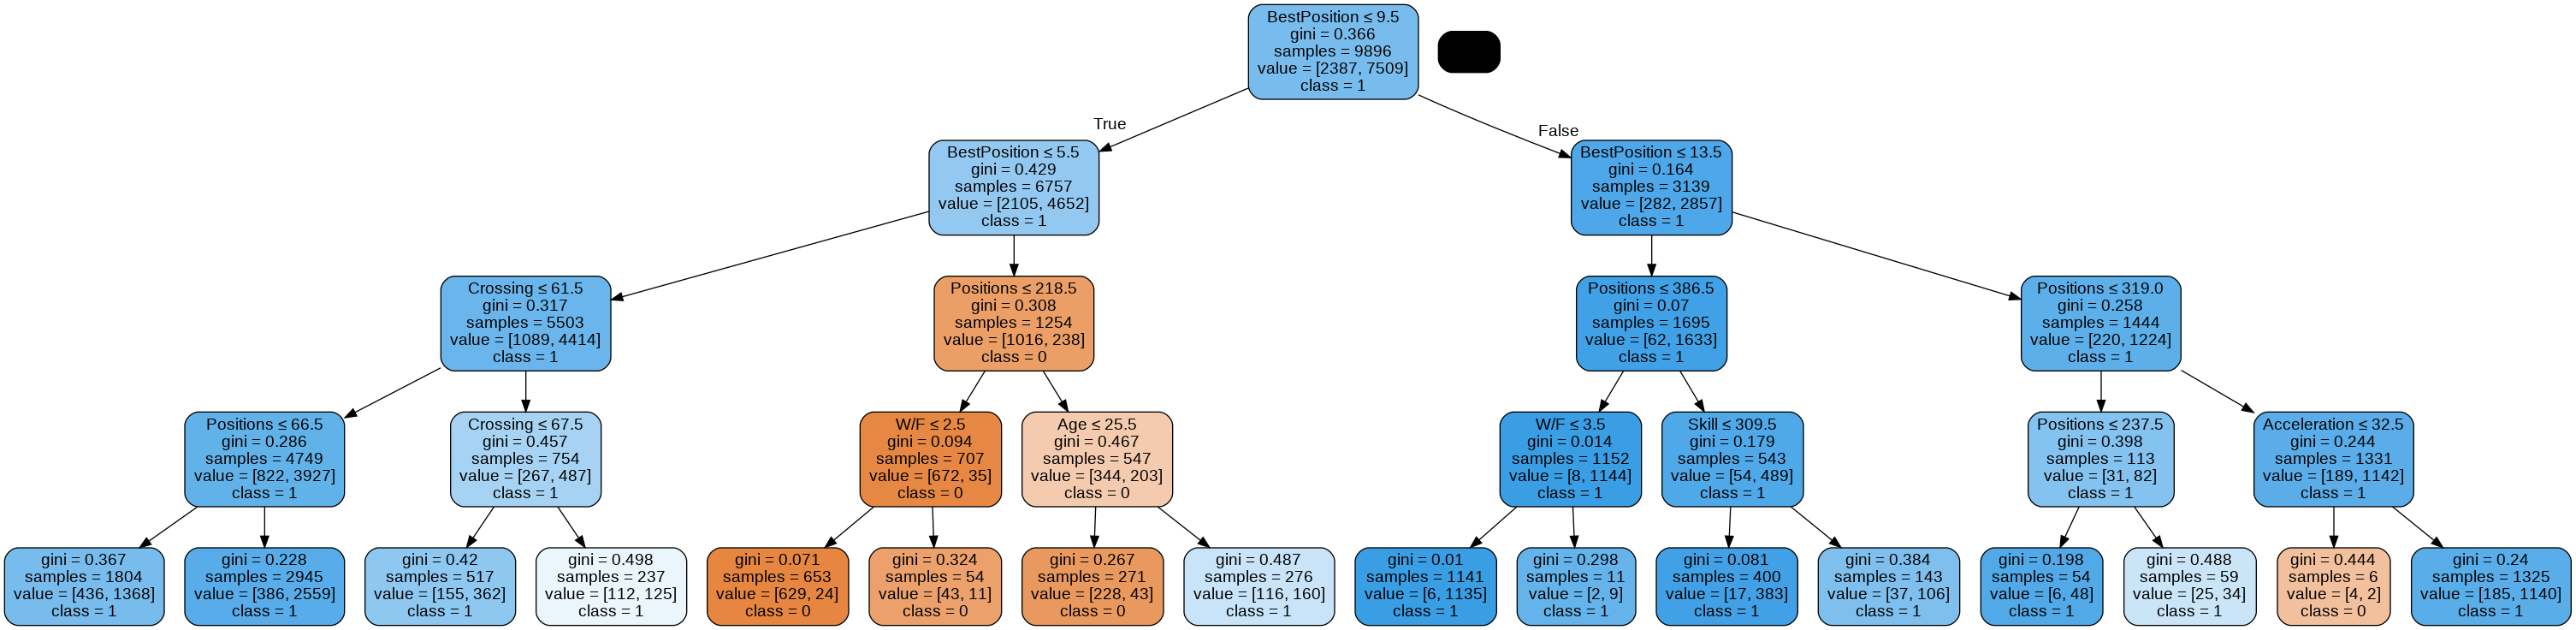

In [ ]:
# Plot decision trees model
dt_data = tree.export_graphviz(dt_model, out_file=None,
                      feature_names = x_train.columns,
                      class_names = ['0','1'],
                      filled=True, rounded=True,
                      special_characters=True)

graph = pydotplus.graph_from_dot_data(dt_data)

Image(graph.create_png())
# value tells how many sample fall in each category
# For example value = 2387 + 7509 = 9896. So, 2387 data points are in the category 0 and 7509 data points belong to category 1.

**SVM**

In [ ]:
# Use a grid search cross validation to find the best C and gamma tunning parameters.
param_grid1 = {'C':[0.1,1,2], 'gamma':[1, 0.1, 0.01,0.001]}
grid = GridSearchCV(svm.SVC(), param_grid = param_grid1, verbose = 3)

# Fit the svm model
grid.fit(x_train,y_train)
# Show the best estimator, the best score, and the best parameter.
print('The best estimator is,',grid.best_estimator_)
print('The best score is,',grid.best_score_)
print('The best parameters are,',grid.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END ....................C=0.1, gamma=1;, score=0.759 total time=  11.1s
[CV 2/5] END ....................C=0.1, gamma=1;, score=0.759 total time=   7.0s
[CV 3/5] END ....................C=0.1, gamma=1;, score=0.759 total time=   5.4s
[CV 4/5] END ....................C=0.1, gamma=1;, score=0.759 total time=   5.5s
[CV 5/5] END ....................C=0.1, gamma=1;, score=0.758 total time=   8.0s
[CV 1/5] END ..................C=0.1, gamma=0.1;, score=0.759 total time=   9.7s
[CV 2/5] END ..................C=0.1, gamma=0.1;, score=0.759 total time=   5.4s
[CV 3/5] END ..................C=0.1, gamma=0.1;, score=0.759 total time=   5.5s
[CV 4/5] END ..................C=0.1, gamma=0.1;, score=0.759 total time=   5.5s
[CV 5/5] END ..................C=0.1, gamma=0.1;, score=0.758 total time=   7.2s
[CV 1/5] END .................C=0.1, gamma=0.01;, score=0.759 total time=   9.2s
[CV 2/5] END .................C=0.1, gamma=0.01;

In [ ]:
# Fit the svm model with an optimized c and gamma tunning parameters
svm_model = svm.SVC(C = 2, gamma = 0.001)
svm_model.fit(x_train,y_train)

# Predict the svm models performance on the test set/validation set
svm_predict = svm_model.predict(x_test)

# Evaluate the svm models prediction
svm_accuracy = accuracy_score(y_test,svm_predict)
print('Accuracy: %.3f' % svm_accuracy)


Accuracy: 0.782
